In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

from IPython.display import Image, display
import keras
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPool2D, BatchNormalization, ZeroPadding2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Conv2D, Activation, Dense, Dropout, MaxPooling2D
import PIL
from PIL import Image, ImageFilter
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile
from tqdm import tqdm
from glob import glob
import cv2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 180
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('C:/Users/Administrateur/OneDrive/Formation DATASCIENCE/Projet DATA SCIENCE/chest_xray/train')
test = get_training_data('C:/Users/Administrateur/OneDrive/Formation DATASCIENCE/Projet DATA SCIENCE/chest_xray/test')
val = get_training_data('C:/Users/Administrateur/OneDrive/Formation DATASCIENCE/Projet DATA SCIENCE/chest_xray/val')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [4]:
IMG_SIZE = 180
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [5]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [6]:
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

x_global = np.concatenate((x_train,x_test),axis=0)
y_global = np.concatenate((y_train,y_test),axis=0)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(x_global, y_global, test_size=0.33, random_state=42)

label =  0


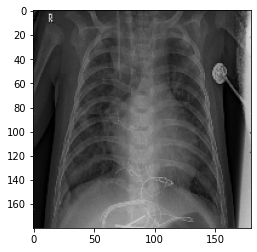

In [8]:
plt.imshow(x_train[0].reshape(180,180), cmap='gray')
print('label = ', Y_train[0])

NameError: name 'random' is not defined

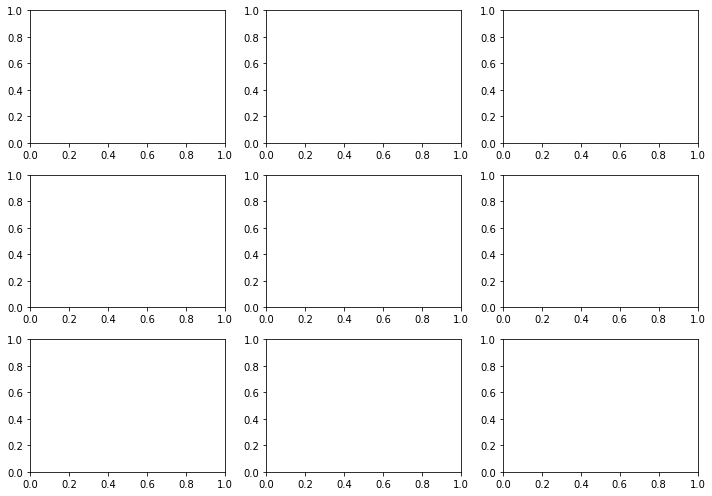

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(10, 7))
ax = ax.ravel()
plt.tight_layout()

for i in range(3):
    random_index = random.randint(0, min(len(x_train), len(x_val), len(x_test)))
    ax[i].imshow(x_train[random_index].reshape(180,180), cmap='gray')
    ax[i].set_title('Set: train, label (Pneumonia =) {}'.format(y_train[random_index]))

    ax[i+3].imshow(x_val[random_index].reshape(180,180), cmap='gray')
    ax[i+3].set_title('Set: val, label (Pneumonia =) {}'.format(y_val[random_index]))

    ax[i+6].imshow(x_test[random_index].reshape(180,180), cmap='gray')
    ax[i+6].set_title('Set: test, label (Pneumonia =) {}'.format(y_test[random_index]))

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
#model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
#model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Dropout(0.2))

model.add(Activation("sigmoid"))
metrics = [
  'accuracy', 
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
]
model.compile(loss='binary_crossentropy', # loss function
              optimizer='adam',                # optimization algorithm
              metrics=metrics)  


In [11]:

training_history = model.fit(X_train, Y_train,
                             validation_split = 0.2,
                             epochs = 25,
                             batch_size = 200)

scores = model.evaluate(X_test, Y_test)

Epoch 1/25
16/16 [==============================] - 144s 9s/step - loss: 0.7153 - accuracy: 0.6224 - precision: 0.3181 - recall: 0.2790 - val_loss: 0.4702 - val_accuracy: 0.7535 - val_precision: 0.8235 - val_recall: 0.1302
Epoch 2/25
16/16 [==============================] - 124s 8s/step - loss: 0.4545 - accuracy: 0.8004 - precision: 0.7526 - recall: 0.4049 - val_loss: 0.3146 - val_accuracy: 0.8608 - val_precision: 0.8232 - val_recall: 0.6279
Epoch 3/25
16/16 [==============================] - 121s 8s/step - loss: 0.3488 - accuracy: 0.8605 - precision: 0.8142 - recall: 0.6354 - val_loss: 0.2341 - val_accuracy: 0.9029 - val_precision: 0.8927 - val_recall: 0.7349
Epoch 4/25
16/16 [==============================] - 122s 8s/step - loss: 0.2796 - accuracy: 0.8939 - precision: 0.8967 - recall: 0.7112 - val_loss: 0.1823 - val_accuracy: 0.9285 - val_precision: 0.8916 - val_recall: 0.8419
Epoch 5/25
16/16 [==============================] - 122s 8s/step - loss: 0.2588 - accuracy: 0.9083 - precisi

In [12]:
def print_results(y_test, y_pred):
    print('Accuracy   : {:.5f}'.format(accuracy_score(y_pred , y_test))) 
    print('AUC        : {:.5f}'.format(roc_auc_score(y_test , y_pred)))
    print('Precision  : {:.5f}'.format(precision_score(y_test , y_pred)))
    print('Recall     : {:.5f}'.format(recall_score(y_test , y_pred)))
    print('F1         : {:.5f}'.format(f1_score(y_test , y_pred)))
    print('Confusion Matrix : \n', confusion_matrix(y_test, y_pred))

In [13]:
predictions = model.predict(x=x_test)
y_pred = np.round(predictions).reshape(1,-1)[0]

In [14]:
print_results(y_test, y_pred)

Accuracy   : 0.92788
AUC        : 0.90385
Precision  : 1.00000
Recall     : 0.80769
F1         : 0.89362
Confusion Matrix : 
 [[390   0]
 [ 45 189]]


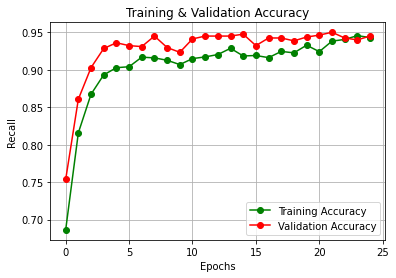

In [15]:
epochs_array = [i for i in range(len(training_history.history['accuracy']))]
fig = plt.figure()
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

plt.plot(epochs_array, train_acc, 'go-', label='Training Accuracy')
plt.plot(epochs_array, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

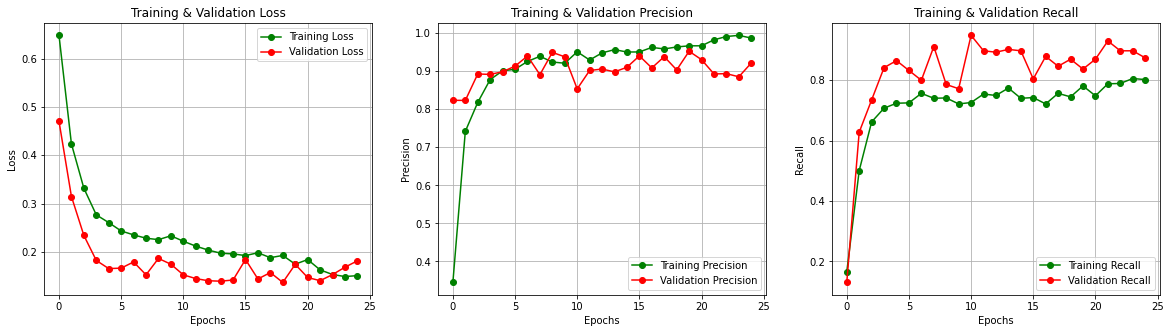

In [16]:
epochs_array = [i for i in range(25)]
fig, ax = plt.subplots(1,3)
train_precision = training_history.history['precision']
train_recall = training_history.history['recall']
train_loss = training_history.history['loss']

val_precision = training_history.history['val_precision']
val_recall = training_history.history['val_recall']
val_loss = training_history.history['val_loss']
fig.set_size_inches(20,5)

ax[0].plot(epochs_array, train_loss, 'g-o', label='Training Loss')
ax[0].plot(epochs_array, val_loss, 'r-o', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

ax[1].plot(epochs_array, train_precision, 'go-', label='Training Precision')
ax[1].plot(epochs_array, val_precision, 'ro-', label='Validation Precision')
ax[1].set_title('Training & Validation Precision')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Precision')
ax[1].grid(True)

ax[2].plot(epochs_array, train_recall, 'go-', label='Training Recall')
ax[2].plot(epochs_array, val_recall, 'ro-', label='Validation Recall')
ax[2].set_title('Training & Validation Recall')
ax[2].legend()
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Recall')
ax[2].grid(True)

plt.show()

In [17]:
incorrect = np.nonzero(y_test != y_pred)[0]

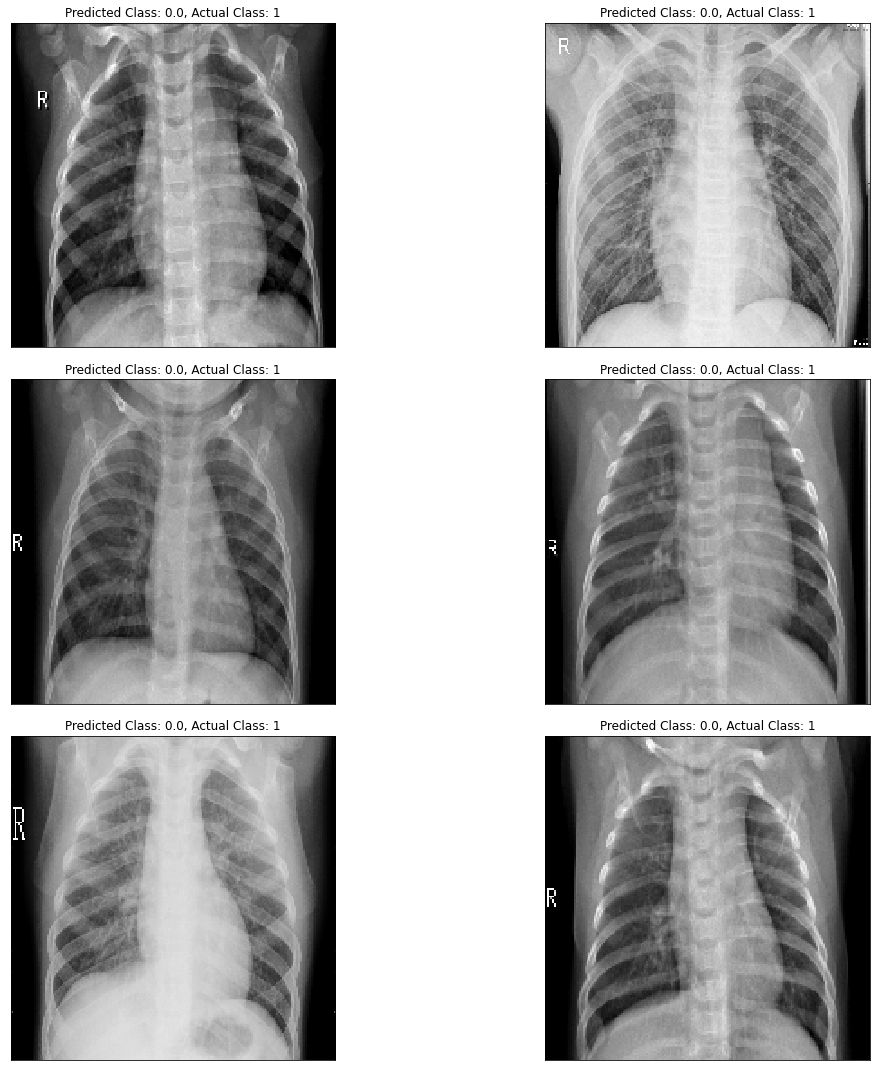

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))
ax = ax.ravel()
plt.subplots_adjust(wspace=0.25, hspace=0.75)
plt.tight_layout()
i = 0
for c in incorrect[:6]:
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(x_test[c].reshape(IMG_SIZE,IMG_SIZE), cmap='gray', interpolation='none')
    ax[i].set_title('Predicted Class: {}, Actual Class: {}'.format(y_pred[c], y_test[c]))
    i += 1 